# KMNIST classification using LightGBM

Solve the MNIST of the crumbling letter as classification problem with LightGBM.  

くずし文字のMNISTをLightGBMで分類問題を解く．

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import lightgbm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
data_path = '/home/jovyan/data/kuzuhsiji'

In [3]:
classes = pd.read_csv(os.path.join(data_path, 'kmnist_classmap.csv'))

##### npz方式とは
Numpyオブジェクトのファイルフォーマットで， `numpy.load` で読み込める．csvファイルよりメモリ効率が高く読み込み速度も早い．

In [4]:
X_train = np.load(os.path.join(data_path, 'kmnist-train-imgs.npz'))['arr_0']
y_train = np.load(os.path.join(data_path, 'kmnist-train-labels.npz'))['arr_0']

X_test = np.load(os.path.join(data_path, 'kmnist-test-imgs.npz'))['arr_0']
y_test = np.load(os.path.join(data_path, 'kmnist-test-labels.npz'))['arr_0']

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Class Labelと平仮名の対応表の作成

In [6]:
print(y_train[0:5])
print(classes)

[8 7 0 1 4]
   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


In [7]:
labelindex = classes.set_index('index').to_dict()['char']

In [8]:
labelindex

{0: 'お',
 1: 'き',
 2: 'す',
 3: 'つ',
 4: 'な',
 5: 'は',
 6: 'ま',
 7: 'や',
 8: 'れ',
 9: 'を'}

In [9]:
print(X_train.max())
print(X_train.min())

255
0


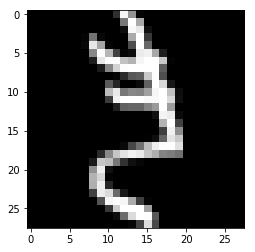

In [10]:
plt.imshow(X_train[423], cmap=plt.cm.gray)
plt.show()

### Data Preprocessing

In [11]:
train_normalization = X_train /255
test_normalization = X_test / 255

In [12]:
train_format = train_normalization.reshape(train_normalization.shape[0], -1)
test_format = test_normalization.reshape(test_normalization.shape[0], -1)

In [13]:
lgb_model = lightgbm.LGBMClassifier()

In [14]:
train_data  = lightgbm.Dataset(train_format, label=y_train)
eval_data = lightgbm.Dataset(test_format, label=y_test, reference=train_data)

In [15]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass' ,
    'num_class': 10,
    'verbose': 2
}

evaluation_results = {}

### Accuracy Callback Method
Create callback function that returns the prediction.  
精度を返すコールバック関数を作成する(Defaultでは定義されてないらしい)

In [24]:
def accuracy(preds, data):
    """
    精度を計算する関数
    """
    y_true = data.get_label()
    N_LABELS = 10
    reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    
    y_pred = np.argmax(reshaped_preds, axis=0)
    acc = np.mean(y_true == y_pred)
    
    return 'accuracy', acc, True

In [25]:
gbm = lightgbm.train(
    params,
    train_data,
    valid_sets=[train_data, eval_data],
    valid_names=['Train', 'Evaluation'],
    evals_result=evaluation_results,
    feval=accuracy,
    num_boost_round=300,
    verbose_eval=20
)

[20]	Train's multi_logloss: 0.710901	Train's accuracy: 0.890017	Evaluation's multi_logloss: 1.11132	Evaluation's accuracy: 0.7244
[40]	Train's multi_logloss: 0.385774	Train's accuracy: 0.929983	Evaluation's multi_logloss: 0.799088	Evaluation's accuracy: 0.7773
[60]	Train's multi_logloss: 0.247742	Train's accuracy: 0.954533	Evaluation's multi_logloss: 0.645093	Evaluation's accuracy: 0.8112
[80]	Train's multi_logloss: 0.170908	Train's accuracy: 0.971167	Evaluation's multi_logloss: 0.5548	Evaluation's accuracy: 0.8317
[100]	Train's multi_logloss: 0.121317	Train's accuracy: 0.983017	Evaluation's multi_logloss: 0.49569	Evaluation's accuracy: 0.8483
[120]	Train's multi_logloss: 0.0882061	Train's accuracy: 0.99065	Evaluation's multi_logloss: 0.455117	Evaluation's accuracy: 0.8591
[140]	Train's multi_logloss: 0.0649866	Train's accuracy: 0.995517	Evaluation's multi_logloss: 0.425965	Evaluation's accuracy: 0.8677
[160]	Train's multi_logloss: 0.0486745	Train's accuracy: 0.99785	Evaluation's multi

In [27]:
train_accuracy = evaluation_results['Train']['accuracy']
eval_accuracy = evaluation_results['Evaluation']['accuracy']
train_loss = evaluation_results['Train']['multi_logloss']
eval_loss = evaluation_results['Evaluation']['multi_logloss']

### Plot Training Results 

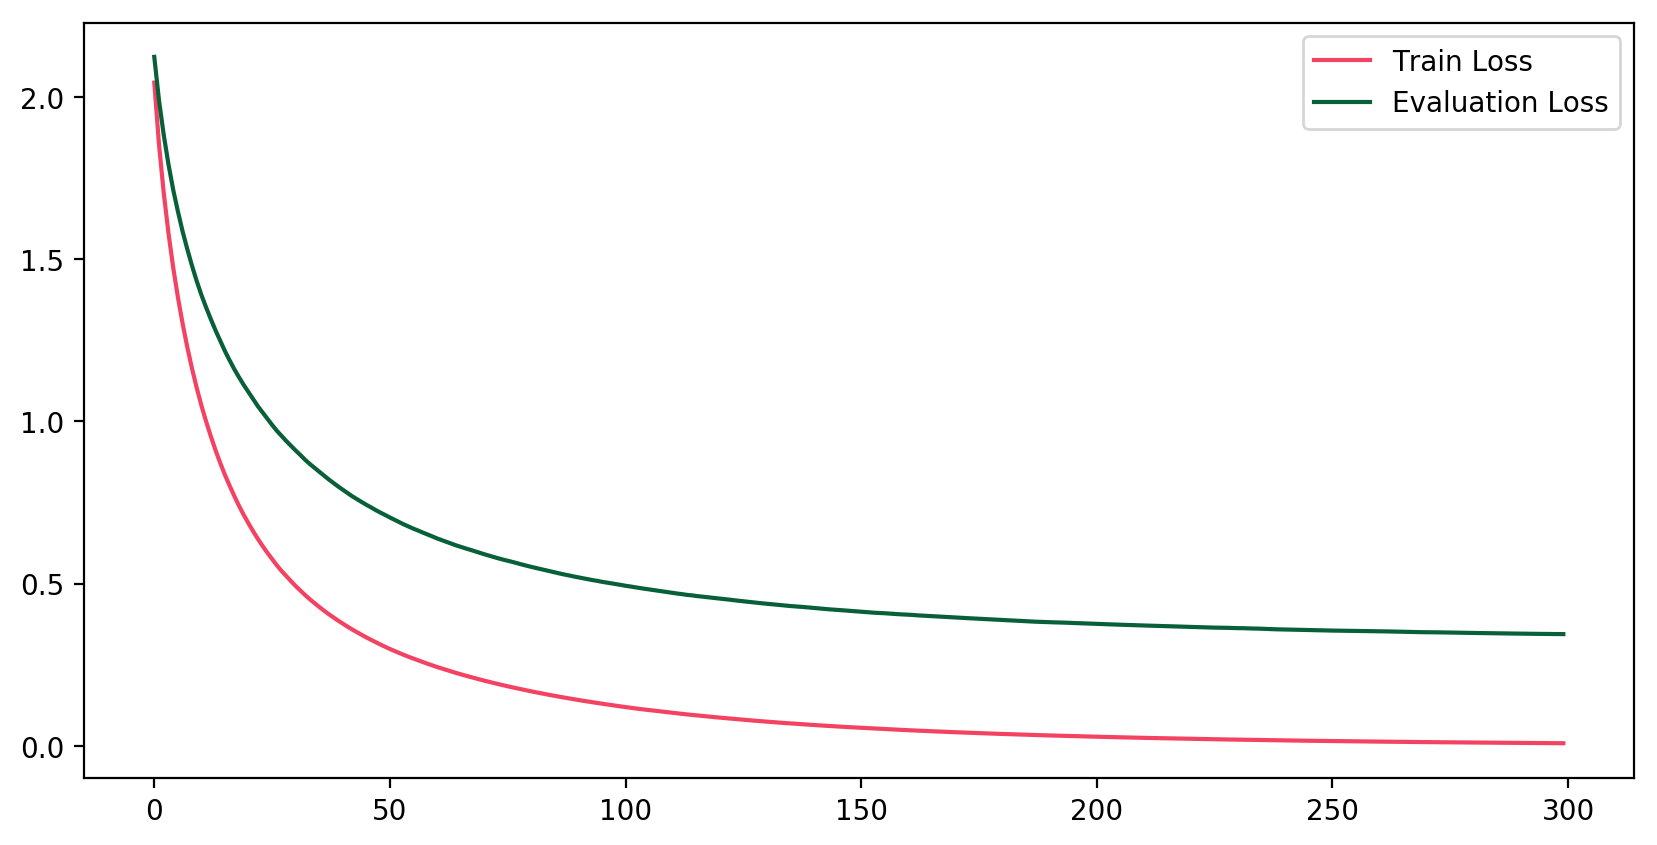

In [22]:
fig = plt.figure(figsize=(10, 5), dpi=200)

sns.lineplot(
    color='#f44262',
    data = np.array(train_loss),
    label = "Train Loss"
)

sns.lineplot(
    color='#086039',
    data = np.array(eval_loss),
    label = "Evaluation Loss"
)

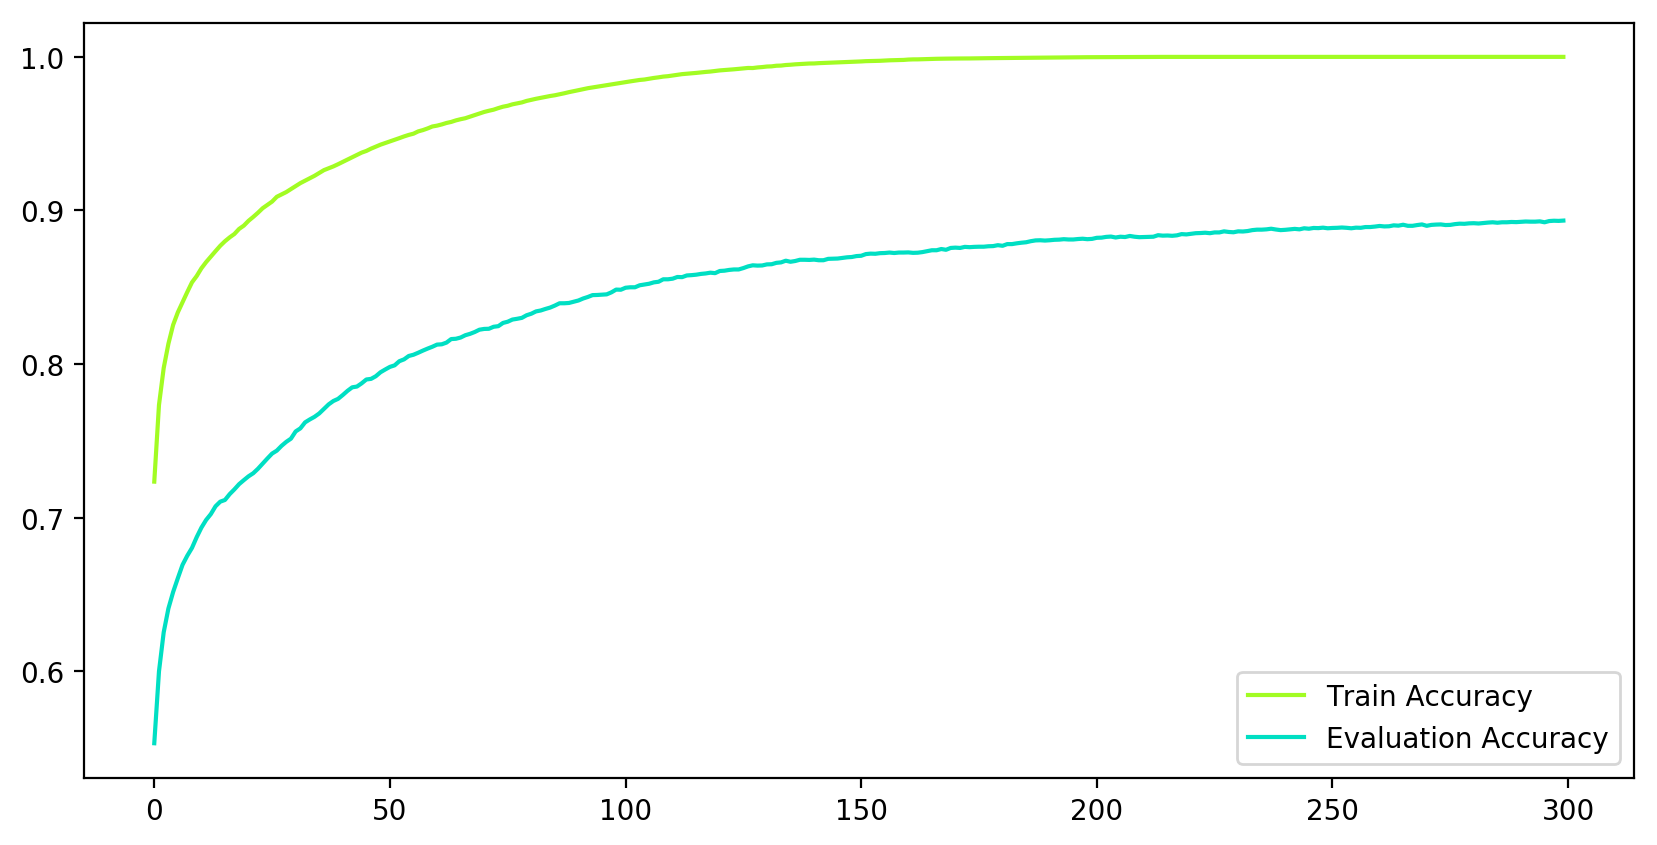

In [28]:
fig = plt.figure(figsize=(10, 5), dpi=200)

sns.lineplot(
    color='#a2fc23', 
    data = np.array(train_accuracy),
    label="Train Accuracy"
)

sns.lineplot(
    color="#00dfc3",
    data = np.array(eval_accuracy),
    label = "Evaluation Accuracy"
)